## Example notebook running SiRCle

In [1]:
from scircm import SciRCM
import pandas as pd

# FORMAT must be csv :) 
data_dir = 'data/'
prot_file = f'{data_dir}prot_DE_Stage IV_sircle.csv'
rna_file = f'{data_dir}rna_DE_Stage IV_sircle.csv'
meth_file = f'{data_dir}filtered_cpg_DE_Stage IV_sircle.csv'



### Had to run this originally but couldn't upload the data since the file was too big
```
from scircm import filter_methylation_data_by_genes
import numpy as np
meth_df = pd.read_csv(meth_file)
# Note: you need to pass it: 
# 1) the gene ID column, here it is 'ensembl_gene_id'
# 2) the padj column: here it is 'padj_meth'
# 3) the logFC or test statistic column: here it is 'CpG_Beta_diff'
# Since we don't have a beta diff between normal and tumour let's make one (used M values)
meth_df['CpG_Beta_diff'] = np.mean(meth_df[[c for c in meth_df.columns if 'Tumor' in c]].values) - np.mean(meth_df[[c for c in meth_df.columns if 'Normal' in c]].values)
filtered_meth_df = filter_methylation_data_by_genes(meth_df, 'ensembl_gene_id', 'padj_meth', 'CpG_Beta_diff')
# Re point the meth file to be the filtered one
meth_file = f'{data_dir}filtered_cpg_DE_Stage IV_sircle.csv'
filtered_meth_df.to_csv(meth_file, index=False)
```

## Have a look at each DF to show what is in it

In [2]:
pd.read_csv(prot_file)

,external_gene_name,ensembl_gene_id,chromosome_name,start_position,end_position,strand,entrezgene_id,external_synonym,hgnc_symbol,original_gene_id,...,Protein_Tumor_C3N.01200_CPT0075130003,Protein_Normal_C3N.01220_CPT0076350001,Protein_Tumor_C3N.01220_CPT0076330003,logFC_protein,stat_protein,pvalue_protein,padj_protein,B_protein,mean_protein,var_protein
0,IFITM2,ENSG00000185201,11,303655.0,309397.0,1.0,10581.0,1-8D,IFITM2,IFITM2,...,17.330488,17.219003,17.368543,0.058697,0.759486,4.548756e-01,0.552655,-6.717889,17.336464,0.035891
1,IFITM3,ENSG00000142089,11,319676.0,329475.0,-1.0,10410.0,1-8U,IFITM3,IFITM3,...,21.389833,20.624301,21.268696,0.342514,4.407527,1.833464e-04,0.000666,0.337124,21.053427,0.066014
2,PRDX6,ENSG00000117592,1,173477330.0,173488815.0,1.0,9588.0,1-Cys,PRDX6,PRDX6,...,25.942430,26.157340,26.136880,-0.053029,-0.852348,4.023229e-01,0.501836,-6.642658,26.016635,0.022394
3,ALDH1L1,ENSG00000144908,3,126103562.0,126197994.0,-1.0,10840.0,10-fTHF,ALDH1L1,ALDH1L1,...,24.198385,25.787163,24.507928,-0.894437,-5.830075,5.017052e-06,0.000031,3.902914,24.983542,0.354569
4,KNOP1,ENSG00000103550,16,19701937.0,19718235.0,-1.0,400506.0,101F10.1,KNOP1,KNOP1,...,18.239034,17.378866,17.962233,0.554211,6.769885,5.038201e-07,0.000005,6.194251,17.687298,0.119714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11350,ZNF827,ENSG00000151612,4,145757627.0,145938823.0,-1.0,152485.0,NaN,ZNF827,ZNF827,...,16.217080,16.252160,16.008280,-0.096421,-0.706508,4.866184e-01,0.583480,-6.757103,16.415587,0.117283
11351,ZNF865,ENSG00000261221,19,55605647.0,55617269.0,1.0,100507290.0,NaN,ZNF865,ZNF865,...,18.350170,18.384890,18.371440,-0.034837,-0.500347,6.213235e-01,0.704386,-6.883668,18.382762,0.028185
11352,ZNF888,ENSG00000213793,19,52904415.0,52923470.0,-1.0,388559.0,NaN,ZNF888,ZNF888,...,14.805210,14.598660,14.825800,0.148483,5.213043,2.319997e-05,0.000113,2.377486,14.738168,0.007968
11353,ZNRD1,ENSG00000066379,NaN,NaN,NaN,NaN,30834.0,NaN,POLR1H,ZNRD1,...,18.610100,18.353800,18.569210,0.096586,1.143102,2.641749e-01,0.359737,-6.355088,18.508131,0.044773


In [3]:
pd.read_csv(rna_file) # Note we can see that the ensembl gene ID column is named Unnamed: 0 this is 
# From DESeq2 having it as the row name

,Unnamed: 0,external_gene_name,entrezgene_id,hgnc_symbol,logFC_rna,stat_rna,pvalue_rna,padj_rna,lfcSE_rna,baseMean_rna,...,RNA_Tumor_C3N.00577_3,RNA_Normal_C3N.01200_1,RNA_Tumor_C3N.01200_1,RNA_Tumor_C3N.01200_2,RNA_Tumor_C3N.01200_3,RNA_Tumor_C3N.01200_4,RNA_Normal_C3N.01220_1,RNA_Tumor_C3N.01220_1,RNA_Tumor_C3N.01220_2,RNA_Tumor_C3N.01220_3
0,ENSG00000000003,TSPAN6,7105.0,TSPAN6,-0.867335,-4.447026,8.706735e-06,3.453242e-05,0.195037,1794.558447,...,5.434883,5.599905,4.629352,4.891962,4.593554,4.837085,5.613410,4.249658,4.867085,5.134165
1,ENSG00000000005,TNMD,64102.0,TNMD,-1.047049,-2.266892,2.339680e-02,4.256510e-02,0.461887,48.809118,...,0.529242,0.948905,0.229404,0.652659,0.677917,0.291472,1.126509,0.282126,0.610286,0.735218
2,ENSG00000000419,DPM1,8813.0,DPM1,0.517629,3.599892,3.183492e-04,9.048072e-04,0.143790,1236.222835,...,5.223657,4.821487,5.428061,4.756430,4.723433,4.983125,4.658032,5.531724,5.371377,5.379116
3,ENSG00000000457,SCYL3,57147.0,SCYL3,-0.007758,-0.104059,9.171225e-01,9.387892e-01,0.074558,1133.146419,...,4.929975,4.745831,4.580305,4.764627,4.647780,4.773554,4.739300,4.750514,4.883110,4.904443
4,ENSG00000000460,C1orf112,55732.0,C1orf112,0.731784,5.833491,5.427942e-09,3.752697e-08,0.125445,412.698772,...,3.433213,2.969224,3.896414,3.577152,3.593571,3.971502,2.658574,2.988328,3.266873,3.487473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33763,ENSG00000281896,NaN,NaN,NaN,-0.098954,-0.695917,4.864808e-01,5.724860e-01,0.142192,206.580354,...,2.509036,2.618644,2.719000,2.450616,2.643508,2.599286,2.519339,2.802318,2.395787,2.447740
33764,ENSG00000281903,LINC02246,NaN,LINC02246,-0.311020,-1.488246,1.366861e-01,1.974510e-01,0.208984,65.953130,...,0.974198,1.440372,2.024264,1.418020,1.364319,1.548652,1.616073,1.183909,1.448970,1.378556
33765,ENSG00000281910,SNORA50A,677830.0,SNORA50A,0.709131,3.867430,1.099884e-04,3.467546e-04,0.183360,23.625336,...,0.723971,0.398676,0.463802,0.569543,0.584824,0.760479,0.660739,0.634094,0.849903,1.024248
33766,ENSG00000281912,LINC01144,400752.0,LINC01144,-0.638175,-2.901953,3.708440e-03,8.291506e-03,0.219912,36.353359,...,1.011987,0.526789,0.601271,0.787500,0.887335,0.488513,1.154666,1.286824,0.928030,1.204567


In [4]:
rna_df = pd.read_csv(rna_file)
rna_df.rename(columns={'Unnamed: 0': 'ensembl_gene_id'}, inplace=True)
rna_df.to_csv(f'{data_dir}rna_DE_Stage IV_sircle_renamed-cols.csv', index=False)
rna_file = f'{data_dir}rna_DE_Stage IV_sircle_renamed-cols.csv'

In [5]:
pd.read_csv(meth_file)

,Unnamed: 0,Locus,chr,pos,Relation_to_Island,UCSC_RefGene_Group,ensembl_gene_id,external_gene_name,hgnc_symbol,entrezgene_id,...,CpG_Normal_2ff2d2ea.9b26.487e.be22.e99d42cc2edb_1,CpG_Normal_db23dcfc.0126.49c5.9705.6e1b79fc7df1_1,CpG_Normal_1660d8a3.5f2d.45a4.820a.aa4990b75a8a_1,CpG_Normal_93eeec61.0fa3.43d0.98b5.6d8acd8e69f1_1,CpG_Normal_1a35f502.10c0.4e9b.8274.5494ea50fff5_1,CpG_Normal_62bcce15.fdaf.49d4.9bed.24a493f5776b_1,CpG_Normal_e3ed1380.d6f1.420e.b6a6.d24a6e81a364_1,CpG_Normal_cb371398.ee48.4665.8089.26229c5b2cf0_1,CpG_Normal_ef9ae1dd.83aa.404d.83ef.ced707ae738b_1,CpG_Beta_diff
0,cg01473187,cg01473187,chrX,100636165,N_Shore,Body,ENSG00000000003,TSPAN6,TSPAN6,7105,...,0.180325,0.473674,0.290601,0.366690,0.213985,0.299311,0.302644,0.368436,0.190726,-0.035676
1,cg16822540,cg16822540,chrX,100584849,OpenSea,1stExon;5'UTR,ENSG00000000005,TNMD,TNMD,64102,...,0.906177,0.630440,0.860365,0.777538,0.726988,0.818062,0.881122,0.849243,0.916830,-0.035676
2,cg14741366,cg14741366,chr20,50955031,N_Shelf,Body,ENSG00000000419,DPM1,DPM1,8813,...,0.973954,0.907073,0.954293,0.934954,0.901875,0.940070,0.950324,0.944920,0.953963,-0.035676
3,cg08245509,cg08245509,chr1,169894353,S_Shore,TSS1500;TSS1500,ENSG00000000457,SCYL3,SCYL3,57147,...,0.057217,0.105343,0.077352,0.086249,0.135714,0.098847,0.039106,0.044032,0.069995,-0.035676
4,cg06093460,cg06093460,chr1,169733700,OpenSea,5'UTR,ENSG00000000460,C1orf112,C1orf112,55732,...,0.873928,0.832325,0.885978,0.861265,0.786526,0.842439,0.840169,0.899528,0.922147,-0.035676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20842,cg12710480,cg12710480,chr20,33666410,N_Shore,Body;Body;TSS200,ENSG00000288649,ACTL10,ACTL10,170487,...,0.258528,0.233961,0.247719,0.166719,0.239548,0.213720,0.266057,0.216800,0.197770,-0.035676
20843,cg11272349,cg11272349,chr2,233728607,OpenSea,Body;Body;Body;Body;Body;Body;Body;Body;TSS1500,ENSG00000288702,UGT1A3,UGT1A3,54659,...,0.912709,0.922216,0.870761,0.884178,0.925671,0.955566,0.886615,0.858294,0.918659,-0.035676
20844,cg23841280,cg23841280,chr2,233713467,OpenSea,Body;Body;Body;Body;Body;1stExon;Body,ENSG00000288705,UGT1A5,UGT1A5,54579,...,0.863748,0.899406,0.822945,0.843668,0.919372,0.889941,0.846407,0.841862,0.862782,-0.035676
20845,cg08037664,cg08037664,chrX,154885717,N_Shore,Body;TSS1500;TSS1500;Body;TSS1500,ENSG00000288722,F8A1,F8A1,8263,...,0.803331,0.815880,0.728846,0.744514,0.860594,0.820578,0.734450,0.705725,0.800652,-0.035676


## Run SiRCle

In [6]:
# Note we assume your methylation CpGs map to a single gene, if they don't see the section below.
# logFC_rna = column name in your RNA file that has your RNA logFC (same for the protein and CpG)
# padj_rna = column name in your RNA file that has your padj value (same for protein and CpG)
# NOTE: these need to be unique from one another since we merge the datasets, if they aren't, you need
# to update your csv files.
# Lastly: ensembl_gene_id this is the gene ID column, All must use the same identifier, and this must be
# labelled the same in each file, if it isn't, update your column names before running.
rcm = SciRCM(meth_file, rna_file, prot_file, 
             "logFC_rna", "padj_rna", "CpG_Beta_diff", "padj_meth", "logFC_protein", "padj_protein",
             "ensembl_gene_id", sep=',',
             rna_padj_cutoff=0.05, 
             prot_padj_cutoff=0.05, 
             meth_padj_cutoff=0.05,
             rna_logfc_cutoff=1.0, 
             prot_logfc_cutoff=0.5, 
             meth_diff_cutoff=0.1, 
             output_dir='',
             non_coding_genes=['None'],
             output_filename='RCM_Output.csv',
             bg_type = '(P&M)|(P&R)|(M&R)'
         )
rcm.run()
df = rcm.get_df()
# That DF now has your rcm clustering results, how easy was that :D
df # The three columns you now have are: Regulation_Grouping_1, Regulation_Grouping_2, Regulation_Grouping_3

,index,ensembl_gene_id,external_gene_name_r,entrezgene_id_r,hgnc_symbol_r,logFC_rna,stat_rna,pvalue_rna,padj_rna,lfcSE_rna,...,stat_protein,pvalue_protein,padj_protein,B_protein,mean_protein,var_protein,Number of significant datasets,Regulation_Grouping_1,Regulation_Grouping_2,Regulation_Grouping_3
0,0,ENSG00000000003,TSPAN6,7105.0,TSPAN6,-0.867335,-4.447026,8.706735e-06,3.453242e-05,0.195037,...,-5.812166,0.000005,0.000032,3.858536,21.147857,0.126135,3.0,TMDS_M--_R--_P-neg,TMDS,TMDS
1,1,ENSG00000000005,TNMD,64102.0,TNMD,-1.047049,-2.266892,2.339680e-02,4.256510e-02,0.461887,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,TPDS_TMDE_M--_R-neg_P--,TPDS_TMDE,TMDE
2,2,ENSG00000000419,DPM1,8813.0,DPM1,0.517629,3.599892,3.183492e-04,9.048072e-04,0.143790,...,-1.864672,0.074319,0.124892,-5.334850,22.540973,0.025876,1.0,None,None,None
3,4,ENSG00000000460,C1orf112,55732.0,C1orf112,0.731784,5.833491,5.427942e-09,3.752697e-08,0.125445,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,None,None,None
4,5,ENSG00000000938,FGR,2268.0,FGR,1.819090,6.582143,4.637163e-11,4.375181e-10,0.276367,...,2.754227,0.010991,0.023954,-3.608018,17.844586,0.167850,1.0,TPDE_TMDS_M--_R-pos_P--,TPDE_TMDS,TMDS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12174,37729,ENSG00000279514,0,0.0,0,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,...,-4.198179,0.000314,0.001063,-0.190967,18.283540,0.539381,1.0,TMDS_M--_R--_P-neg,TMDS,TMDS
12175,37747,ENSG00000281184,0,0.0,0,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,...,4.159683,0.000343,0.001147,-0.278621,24.400029,0.017435,1.0,None,None,None
12176,37751,ENSG00000281670,0,0.0,0,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,...,2.790976,0.010057,0.022188,-3.526349,20.298545,0.035301,1.0,None,None,None
12177,37766,ENSG00000283104,0,0.0,0,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,...,-5.874615,0.000004,0.000028,4.034866,24.253333,0.065493,1.0,None,None,None


## Plot the clusters

Text(0.5, 1.0, 'Clustered Stage IV patients')

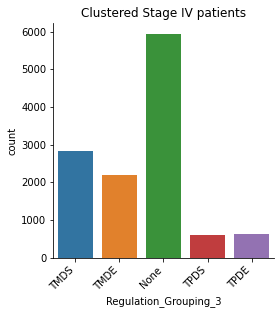

In [7]:
import itertools
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.catplot(data=df, x='Regulation_Grouping_3', kind="count", 
               height=4)
plt.xticks(rotation=45, ha='right')
plt.title(f'Clustered Stage IV patients')

### Save DF to a file

In [8]:
df.to_csv(f'{data_dir}RCM.csv', index=False)

## Look at enriched TF's

     Unnamed: 0  tf confidence  target  mor
480         481  AR          A   ABCE1    1
481         482  AR          A  ACAD10    1
482         483  AR          A    ACP3    1
483         484  AR          A    AHSG    1
484         485  AR          A  AKR1B1    1
--------------------------------------------------------------------------------
WARN: no background ID set, using all genes in the supplied DF as the background.
Number of genes: 	1939	
--------------------------------------------------------------------------------


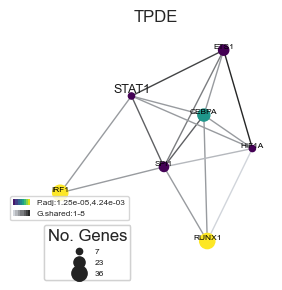

<Figure size 300x300 with 0 Axes>

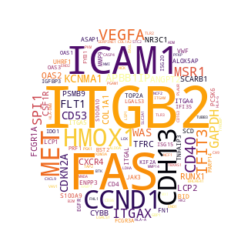

In [18]:
from scimotf import SciMotf_Doro
from scimotf import plot_cluster_tf

rcm_file = f'{data_dir}RCM.csv'
tf_file = f'{data_dir}dorothea_hs_ABCD.csv'
mo = SciMotf_Doro(doro_file=tf_file, cluster_file=rcm_file, 
                  cluster_gene_id='external_gene_name', # got to match motif
                  padj_protein='padj_protein', logfc_protein='logFC_protein', padj_rna='padj_rna',
                  logfc_rna='logFC_rna', output_dir=data_dir)

df = mo.run(['A'], rcm_clusters=["TMDE", "TMDS", "MDS", "MDE", "TPDE", "TPDS"])
df.to_csv(f'{data_dir}scimotif_DORO_A.csv')
plot_cluster_tf(f'{data_dir}scimotif_DORO_A.csv', save_fig=False)

## Train model and compare two groups

### First setup the data

In [10]:
# Load in the files that we used for DE analysis and remove any redundent columns
# the VAE excpets just the ID as the index, and then the values
df = pd.read_csv(f'{data_dir}RCM.csv')

# First filter out any NA values (we're not interested in non SiRCle genes)
rcm_df = df[df['Regulation_Grouping_3'] != 'None']

rna_sample_file = f'{data_dir}rna_sample_data_Stage IV_sircle.csv'
prot_sample_file = f'{data_dir}prot_sample_data_Stage IV_sircle.csv'
# Now we want to merge the clinical info with the cases from the sample df
meth_sample_file = f'{data_dir}cpg_sample_data_Stage IV_sircle.csv'

rna_samples = list(pd.read_csv(rna_sample_file)['FullLabel'].values)
prot_samples = list(pd.read_csv(prot_sample_file)['FullLabel'].values)
meth_samples = list(pd.read_csv(meth_sample_file)['FullLabel'].values)
# Only use the filtered i.e. one CpG to one gene mapping for the cpg data

# ensembl_gene_id that same shared gene ID
cpg_data_df = rcm_df[['ensembl_gene_id'] + meth_samples]
rna_data_df = rcm_df[['ensembl_gene_id'] + rna_samples]
protein_data_df = rcm_df[['ensembl_gene_id'] + prot_samples]


meta_cols = ['ensembl_gene_id', 'external_gene_name', 'entrezgene_id', 'hgnc_symbol', "logFC_rna", "padj_rna", 
             "CpG_Beta_diff", "padj_meth", "logFC_protein", "padj_protein", "Regulation_Grouping_2"]


# Save to input dir
save_input_data = True
meta_rcm_df = rcm_df[meta_cols].copy()
meta_rcm_df.set_index('ensembl_gene_id', inplace=True)
# Save to the input data dir folder.
if save_input_data:
    protein_data_df.to_csv(f'{data_dir}CPTAC_protein.csv', index=False)
    rna_data_df.to_csv(f'{data_dir}CPTAC_rna.csv', index=False)
    cpg_data_df.to_csv(f'{data_dir}CPTAC_cpg.csv', index=False)
    meta_rcm_df.to_csv(f'{data_dir}RCM.csv')

In [11]:
# Example sample data frame
pd.read_csv(rna_sample_file)

,Unnamed: 0,SampleId,CondId,FullLabel,CondName,SafeCases,gender,TumorStage,AgeGrouped,BMIGrouped,...,CIMPStatus,GenomeInstability,VHL+TTN,VHL-TTN,VHL+PBRM1,VHL-PBRM1,PBRM1-VHL,VHL,TTN-VHL,TTN+PBRM1-VHL
0,C3L-00011,6b60f8f0-8e63-4669-b923-3023190d52e7,0,RNA_Normal_C3L.00011_1,Normal,C3L.00011,Female,Stage IV,old,between,...,1,1,1,0,0,1,0,0,0,0
1,C3L-00011,d203d100-f6f3-48f6-bb11-0195a86769d1,1,RNA_Tumor_C3L.00011_1,Tumor,C3L.00011,Female,Stage IV,old,between,...,1,1,1,0,0,1,0,0,0,0
2,C3L-00096,30a1f914-0dde-4f60-ae21-1d5d33c5f6f0,0,RNA_Normal_C3L.00096_1,Normal,C3L.00096,Male,Stage IV,middle,between,...,1,0,0,1,0,1,0,1,0,0
3,C3L-00096,52447ca4-bf8a-4c63-9979-58a2bf548b40,1,RNA_Tumor_C3L.00096_1,Tumor,C3L.00096,Male,Stage IV,middle,between,...,1,0,0,1,0,1,0,1,0,0
4,C3L-01281,5e27240a-a5a0-4b2c-80a6-91f08ad36098,0,RNA_Normal_C3L.01281_1,Normal,C3L.01281,Male,Stage IV,old,between,...,0,0,0,1,1,0,0,0,0,0
5,C3L-01281,226d1c49-68e8-4397-87ae-650968498832,1,RNA_Tumor_C3L.01281_1,Tumor,C3L.01281,Male,Stage IV,old,between,...,0,0,0,1,1,0,0,0,0,0
6,C3L-01287,bd806985-4de7-4f07-8559-bc1692d03937,0,RNA_Normal_C3L.01287_1,Normal,C3L.01287,Male,Stage IV,old,between,...,1,0,0,1,0,1,0,1,0,0
7,C3L-01287,ce55e102-f45f-4ea0-bc72-ab19482a9645,1,RNA_Tumor_C3L.01287_1,Tumor,C3L.01287,Male,Stage IV,old,between,...,1,0,0,1,0,1,0,1,0,0
8,C3L-01287,0a1a14f8-3e7a-44ae-a7ef-c0ae33a66975,1,RNA_Tumor_C3L.01287_2,Tumor,C3L.01287,Male,Stage IV,old,between,...,1,0,0,1,0,1,0,1,0,0
9,C3N-00149,af2f69dd-738e-4d3a-bc9b-75b8872a68cf,0,RNA_Normal_C3N.00149_1,Normal,C3N.00149,Female,Stage IV,old,between,...,1,1,0,1,0,1,0,1,0,0


### Next train the model

In [12]:
from scircm import RCMStats
missing_method='mean'
label = missing_method
sv = RCMStats(rcm_file=f'{data_dir}RCM.csv', 
              patient_sample_file=f'{data_dir}clinical_CPTAC_TCGA.csv', # Clinical file for all patients in the study
              meth_file=f'{data_dir}CPTAC_cpg.csv', 
              meth_sample_file=meth_sample_file, 
              rna_file=f'{data_dir}CPTAC_rna.csv', 
              rna_sample_file=rna_sample_file,
              protein_file=f'{data_dir}CPTAC_protein.csv', 
              protein_sample_file=prot_sample_file,
              output_folder=data_dir, 
              column_id='FullLabel',
              condition_column='CondId',
              patient_id_column='SafeCases', # This is the column that is in each of the sample DFs
              run_name=label,
              normalise='rows', 
              verbose=True,
             missing_method=missing_method)

# Check out the patient info
# Get the patient info that has been compiled from the provided sample files
patient_info = sv.patient_clinical_df
# Select the cases with 5 samples 
matching_patient_info = patient_info[patient_info['Sample counts'] == 5]
matching_cases = matching_patient_info['SafeCases'].values
print("total number of patients: ", len(patient_info), " vs number with matching data: ", len(matching_patient_info))
matching_cases

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Overlap between SiRCLe gene clusters and protein, RNA, and CpG: 	6250	
	If you used SiRCLe, this should be the total number of genes in your SiRCLe dataset. 6250	
 First 5 gene IDs in RCM: 	['ENSG00000196228', 'ENSG00000075420', 'ENSG00000189099', 'ENSG00000133574', 'ENSG00000135185']	
 First 5 gene IDs in Protein: 	['ENSG00000196228', 'ENSG00000075420', 'ENSG00000189099', 'ENSG00000133574', 'ENSG00000135185']	
 First 5 gene IDs in RNA: 	['ENSG00000196228', 'ENSG00000075420', 'ENSG00000189099', 'ENSG00000133574', 'ENSG00000135185']	
 First 5 gene IDs in Methylation: 	['ENSG00000196228', 'ENSG00000075420', 'ENSG00000189099', 'ENSG00000133574', 'ENSG00000135185']	
--------------------------------------------------------------------------------
-----

array(['C3L.00011', 'C3L.00096', 'C3L.01287', 'C3N.00149', 'C3N.00150',
       'C3N.00194', 'C3N.00390', 'C3N.01200', 'C3N.01220'], dtype=object)

## Train or re-load saved version

In [13]:
train = False
if train:
    epochs = 100 
    batch_size = 16
    num_nodes = 5
    mmd_weight = 0.25
    loss = {'loss_type': 'mse', 'distance_metric': 'mmd', 'mmd_weight': mmd_weight}
    config = {"loss": loss,
              "encoding": {"layers": [{"num_nodes": num_nodes, "activation_fn": "relu"}]},
              "decoding": {"layers": [{"num_nodes": num_nodes, "activation_fn": "relu"}]},
              "latent": {"num_nodes": 1},
              "optimiser": {"params": {'learning_rate': 0.01}, "name": "adam"},
              "epochs": epochs,
              "batch_size": batch_size,
              "scale_data": False
              }
    training_cases = matching_cases # Use matching cases for training
    sv.train_vae(cases=matching_cases, config=config)
    sv.save()  # Save the information we have generated.
else:
    sv.load_saved_vaes()
    sv.load_saved_encodings(f'{sv.output_folder}encoded_df_{label}.csv')
    sv.load_saved_inputs(f'{sv.output_folder}vae_input_df_{label}.csv')
    sv.load_saved_raws(f'{sv.output_folder}raw_input_df_{label}.csv')

7
--------------------------------------------------------------------------------
                               Encoder summary:	                                
--------------------------------------------------------------------------------
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 default_input (InputLayer)     [(None, 7)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 5)            40          ['default_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 1)            6           ['dense[0][0]']                  
                                             

2022-07-11 12:06:32.539804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


7
--------------------------------------------------------------------------------
                               Encoder summary:	                                
--------------------------------------------------------------------------------
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 default_input (InputLayer)     [(None, 7)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 5)            40          ['default_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 1)            6           ['dense_3[0][0]']                
                                             

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 1)]               0         
                                                                 
 dense_10 (Dense)            (None, 5)                 10        
                                                                 
 dense_11 (Dense)            (None, 7)                 42        
                                                                 
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________
None
7
--------------------------------------------------------------------------------
                               Encoder summary:	                                
--------------------------------------------------------------------------------
Model: "encoder"
_____________________________________________________________________________

## Run the statistics on some different comparisons

This works based on stuff in our sample data frame.

We have a very small dataset (just the stage IV patients) so lets see, maybe just look at gender...

In [14]:
# Example sample data frame
sv.patient_clinical_df

,SafeCases,case_id,gender,TumorStage,AgeGrouped,BMIGrouped,RaceGrouped,MTOR_mutation,VHL_mutation,SETD2_mutation,...,tcga_case_id,Stage,BAP1&PBRM1,Protein Tumour,Protein Normal,RNA Tumour,RNA Normal,CpG Tumour,CpG Normal,Sample counts
0,C3L.00011,C3L-00011,Female,Stage IV,old,between,White,0,1,0,...,NaN,Late,NaN,Protein_Tumor_C3L.00011_CPT0001340003,Protein_Normal_C3L.00011_CPT0001350001,RNA_Tumor_C3L.00011_1,RNA_Normal_C3L.00011_1,CpG_Tumor_C3L.00011_1,None,5
1,C3L.00096,C3L-00096,Male,Stage IV,middle,between,White,0,1,0,...,NaN,Late,NaN,Protein_Tumor_C3L.00096_CPT0001180009,Protein_Normal_C3L.00096_CPT0001190001,RNA_Tumor_C3L.00096_1,RNA_Normal_C3L.00096_1,CpG_Tumor_C3L.00096_1,None,5
2,C3L.01281,C3L-01281,Male,Stage IV,old,between,White,0,1,0,...,NaN,Late,PBRM1,Protein_Tumor_C3L.01281_CPT0079480003,Protein_Normal_C3L.01281_CPT0079510001,RNA_Tumor_C3L.01281_1,RNA_Normal_C3L.01281_1,None,None,4
3,C3L.01287,C3L-01287,Male,Stage IV,old,between,White,0,1,0,...,NaN,Late,BAP1,Protein_Tumor_C3L.01287_CPT0079410003,Protein_Normal_C3L.01287_CPT0079430001,RNA_Tumor_C3L.01287_1,RNA_Normal_C3L.01287_1,CpG_Tumor_C3L.01287_1,None,5
4,C3N.00149,C3N-00149,Female,Stage IV,old,between,White,0,1,0,...,NaN,Late,NaN,Protein_Tumor_C3N.00149_CPT0084560003,Protein_Normal_C3N.00149_CPT0084590001,RNA_Tumor_C3N.00149_1,RNA_Normal_C3N.00149_1,CpG_Tumor_C3N.00149_1,None,5
5,C3N.00150,C3N-00150,Female,Stage IV,middle,normal,White,0,0,0,...,NaN,Late,NaN,Protein_Tumor_C3N.00150_CPT0066480003,Protein_Normal_C3N.00150_CPT0066520001,RNA_Tumor_C3N.00150_1,RNA_Normal_C3N.00150_1,CpG_Tumor_C3N.00150_1,None,5
6,C3N.00194,C3N-00194,Female,Stage IV,middle,between,White,0,1,0,...,NaN,Late,NaN,Protein_Tumor_C3N.00194_CPT0014160003,Protein_Normal_C3N.00194_CPT0014130001,RNA_Tumor_C3N.00194_1,RNA_Normal_C3N.00194_1,CpG_Tumor_C3N.00194_1,None,5
7,C3N.00390,C3N-00390,Male,Stage IV,old,between,Slavonic,0,1,0,...,NaN,Late,NaN,Protein_Tumor_C3N.00390_CPT0017410003,Protein_Normal_C3N.00390_CPT0017450001,RNA_Tumor_C3N.00390_1,RNA_Normal_C3N.00390_1,CpG_Tumor_C3N.00390_1,None,5
8,C3N.00491,C3N-00491,Male,Stage IV,middle,between,White,0,1,1,...,NaN,Late,PBRM1,Protein_Tumor_C3N.00491_CPT0012670003,Protein_Normal_C3N.00491_CPT0012640003,None,RNA_Normal_C3N.00491_1,CpG_Tumor_C3N.00491_1,None,4
9,C3N.00577,C3N-00577,Male,Stage IV,old,normal,Asian,0,0,0,...,NaN,Late,NaN,Protein_Tumor_C3N.00577_CPT0069160003,Protein_Normal_C3N.00577_CPT0069190001,RNA_Tumor_C3N.00577_1,RNA_Normal_C3N.00577_1,None,None,4


In [15]:
from sciutil import SciUtil
u = SciUtil()
u.warn_p(['Gender']) # Got to be the column name in the DF and then two of the conditions in that column
# Note if you get something like: ValueError: `x` and `y` must be of nonzero size. 
# Probably means you didn't have enough patients to do this comparison.
gender_df = sv.run_vae_stats(cond_label='gender', cond0='Female', cond1='Male')

--------------------------------------------------------------------------------
                                    Gender	                                     
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Summary
	Cond1: 4 vs Cond0: 5
	       mannwhitneyu stat (Male-Female)  Integrated padj (Male-Female)  \
count                       447.000000                     447.000000   
mean                          9.572707                       0.987279   
std                           3.898196                       0.014944   
min                           0.000000                       0.886905   
25%                           7.000000                       0.988823   
50%                          10.000000                       0.988823   
75%                          12.000000                       0.988823   
max                          20.000000                       

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scircm/stats.py:418: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_stats = all_stats.append(stats_df)


--------------------------------------------------------------------------------
Summary
	Cond1: 4 vs Cond0: 5
	       mannwhitneyu stat (Male-Female)  Integrated padj (Male-Female)  \
count                      1929.000000                    1929.000000   
mean                          9.573354                       0.955107   
std                           4.165275                       0.034057   
min                           0.000000                       0.900560   
25%                           6.000000                       0.935726   
50%                          10.000000                       0.950902   
75%                          13.000000                       1.000000   
max                          20.000000                       1.000000   

       Integrated pval (Male-Female)  Integrated diff (Male-Female)  \
count                    1929.000000                    1929.000000   
mean                        0.546586                      -0.045113   
std              

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scircm/stats.py:418: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_stats = all_stats.append(stats_df)


--------------------------------------------------------------------------------
Summary
	Cond1: 4 vs Cond0: 5
	       mannwhitneyu stat (Male-Female)  Integrated padj (Male-Female)  \
count                      2382.000000                    2382.000000   
mean                         10.133921                       0.964753   
std                           4.140451                       0.026840   
min                           0.000000                       0.938918   
25%                           7.000000                       0.938918   
50%                          10.000000                       0.954098   
75%                          13.000000                       1.000000   
max                          20.000000                       1.000000   

       Integrated pval (Male-Female)  Integrated diff (Male-Female)  \
count                    2382.000000                    2382.000000   
mean                        0.551757                       0.013116   
std              

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scircm/stats.py:418: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_stats = all_stats.append(stats_df)


--------------------------------------------------------------------------------
Summary
	Cond1: 4 vs Cond0: 5
	       mannwhitneyu stat (Male-Female)  Integrated padj (Male-Female)  \
count                       601.000000                     601.000000   
mean                          9.367720                       0.997212   
std                           3.801696                       0.005668   
min                           0.000000                       0.953968   
25%                           7.000000                       0.997728   
50%                           9.000000                       0.997728   
75%                          12.000000                       0.997728   
max                          20.000000                       1.000000   

       Integrated pval (Male-Female)  Integrated diff (Male-Female)  \
count                     601.000000                     601.000000   
mean                        0.586377                      -0.091320   
std              

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scircm/stats.py:418: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_stats = all_stats.append(stats_df)


--------------------------------------------------------------------------------
Summary
	Cond1: 4 vs Cond0: 5
	       mannwhitneyu stat (Male-Female)  Integrated padj (Male-Female)  \
count                       636.000000                     636.000000   
mean                         11.990566                       0.832201   
std                           4.185077                       0.149309   
min                           0.000000                       0.448677   
25%                           9.000000                       0.738676   
50%                          12.000000                       0.899067   
75%                          15.000000                       0.926908   
max                          20.000000                       1.000000   

       Integrated pval (Male-Female)  Integrated diff (Male-Female)  \
count                     636.000000                     636.000000   
mean                        0.505466                       0.251971   
std              

/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scircm/stats.py:418: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_stats = all_stats.append(stats_df)
/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/scircm/stats.py:418: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_stats = all_stats.append(stats_df)


In [16]:
gender_df

,id,mannwhitneyu stat (Male-Female),Integrated padj (Male-Female),Integrated pval (Male-Female),Integrated diff (Male-Female),Integrated mean (Female),Integrated mean (Male),Female_C3L.00011,Female_C3N.00150,Female_C3N.00194,...,Regulation_Grouping_2,Protein-LogFC mean (Male),Protein-LogFC mean (Female),Protein-LogFC mean (Male-Female),RNA-LogFC mean (Male),RNA-LogFC mean (Female),RNA-LogFC mean (Male-Female),CpG-LogFC mean (Male),CpG-LogFC mean (Female),CpG-LogFC mean (Male-Female)
0,ENSG00000000003,9.0,0.988823,0.904762,-0.273112,-0.600593,-0.873705,-0.770941,-0.167657,0.366326,...,TMDS,-0.510505,-0.656886,0.146381,-0.804050,-0.828745,0.024694,0.221875,0.212049,0.009826
1,ENSG00000001630,5.0,0.988823,0.285714,-1.599285,0.470791,-1.128495,0.412410,0.844779,0.489451,...,TMDS,-0.623904,-0.464143,-0.159761,-0.749631,0.013591,-0.763223,-0.054383,-0.030121,-0.024262
2,ENSG00000004455,9.0,0.988823,0.904762,0.070865,0.183142,0.254006,0.637855,0.165503,0.253642,...,TMDS,-0.670830,-0.595900,-0.074931,-0.137235,-0.055657,-0.081578,-0.113638,-0.166474,0.052836
3,ENSG00000004779,12.0,0.988823,0.730159,0.341044,0.509872,0.850916,0.986557,0.499841,0.644504,...,TMDS,-0.601915,-0.642258,0.040343,0.395675,0.246271,0.149403,-0.051424,-0.074292,0.022868
4,ENSG00000004846,1.0,0.946032,0.031746,-0.976901,0.926231,-0.050670,2.480842,0.531593,0.196235,...,TMDS,-0.632687,-0.660922,0.028235,0.308951,1.424291,-1.115339,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,ENSG00000262418,15.0,0.981763,0.285714,0.232890,-0.530650,-0.297760,-0.330597,-0.405308,-0.205515,...,TMDE,1.353405,0.736056,0.617349,0.000000,0.000000,0.000000,-0.137041,-0.115325,-0.021716
251,ENSG00000274233,14.0,0.981763,0.412698,0.303450,-0.866690,-0.563240,-0.702313,-0.543726,-0.537912,...,TMDE,1.008106,0.313787,0.694318,0.000000,0.000000,0.000000,-0.371031,-0.321348,-0.049684
252,ENSG00000276725,8.0,0.981763,0.730159,-0.062165,-0.328453,-0.390618,-0.168080,-0.099073,-0.520294,...,TMDE,0.852553,0.895252,-0.042699,0.000000,0.000000,0.000000,-0.079744,-0.155309,0.075565
253,ENSG00000278154,13.0,0.981763,0.555556,0.053024,-0.464704,-0.411680,-0.486658,-0.440272,0.039552,...,TMDE,1.112496,1.023279,0.089217,0.000000,0.000000,0.000000,-0.135582,-0.270462,0.134880


In [17]:
gender_df[gender_df['Integrated pval (Male-Female)'] < 0.05]

,id,mannwhitneyu stat (Male-Female),Integrated padj (Male-Female),Integrated pval (Male-Female),Integrated diff (Male-Female),Integrated mean (Female),Integrated mean (Male),Female_C3L.00011,Female_C3N.00150,Female_C3N.00194,...,Regulation_Grouping_2,Protein-LogFC mean (Male),Protein-LogFC mean (Female),Protein-LogFC mean (Male-Female),RNA-LogFC mean (Male),RNA-LogFC mean (Female),RNA-LogFC mean (Male-Female),CpG-LogFC mean (Male),CpG-LogFC mean (Female),CpG-LogFC mean (Male-Female)
4,ENSG00000004846,1.0,0.946032,0.031746,-0.976901,0.926231,-0.050670,2.480842,0.531593,0.196235,...,TMDS,-0.632687,-0.660922,0.028235,0.308951,1.424291,-1.115339,0.000000,0.000000,0.000000
25,ENSG00000068697,19.0,0.946032,0.031746,0.699042,0.004412,0.703453,0.276265,-0.088293,0.127706,...,TMDS,-0.425517,-0.711514,0.285997,0.499520,-0.098649,0.598170,-0.156522,-0.026921,-0.129600
31,ENSG00000078668,0.0,0.886905,0.015873,-1.082997,0.931071,-0.151927,0.840780,1.524247,0.378245,...,TMDS,-0.616140,-0.487652,-0.128488,-0.246982,0.240633,-0.487615,-0.067752,-0.253100,0.185348
47,ENSG00000099800,0.0,0.886905,0.015873,-0.571118,0.166755,-0.404364,0.310346,0.003242,0.316381,...,TMDS,-0.596285,-0.649558,0.053273,-0.522712,-0.114094,-0.408618,0.000000,0.000000,0.000000
98,ENSG00000114115,0.0,0.886905,0.015873,-1.984313,0.586854,-1.397459,1.033680,0.654523,0.223197,...,TMDS,-1.121250,-0.731056,-0.390194,-1.091403,-0.081812,-1.009590,0.127681,0.085163,0.042518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,ENSG00000140464,19.0,0.899471,0.031746,0.699832,0.472945,1.172777,0.565427,0.643471,-0.179637,...,TMDE,0.708622,0.429026,0.279596,1.249504,0.787607,0.461897,-0.046185,-0.028514,-0.017671
141,ENSG00000148841,19.0,0.899471,0.031746,0.852758,-0.510076,0.342682,-1.193677,0.164143,-0.340954,...,TMDE,0.714331,0.316145,0.398186,0.725884,-0.067913,0.793797,-0.366160,-0.385292,0.019133
154,ENSG00000160310,0.0,0.899471,0.015873,-0.947208,1.338553,0.391345,1.744450,0.880419,1.856865,...,TMDE,0.803425,0.698708,0.104717,0.261882,0.759666,-0.497783,0.000000,0.000000,0.000000
242,ENSG00000172232,19.0,0.899471,0.031746,0.479186,-1.035119,-0.555934,-0.952788,-0.665807,-1.223141,...,TMDE,0.893528,0.046290,0.847238,0.000000,0.000000,0.000000,-0.355263,-0.343086,-0.012178


### Interpretation

Note, we can see that when comparing "male" and "female" we get no significant differences (using p.adj).
We have two small groups here (Cond1: 4 vs Cond0: 5) and we're using a mann Whitney U test, which means that the ranks would basically need to be all different to get a significant p-value, and then this gets adjusted out. Things to just be wary of :)

Why you ask do we only have 4 vs 5, it's because some of the patients are missing tumour data, we omit these from the analysis, and the inlcude missing currently is only for the patients with a normal sample missing. If you really want to include those patients, impute the missing tumour data for them (though this would be probably a bad idea).

This was an example using a small dataset (because github limits the file size to 50MB), so try with your own data and if you get stuck please get in contact :) we're happy to help out!

Final caveat that while we're using the column "gender" it may refer to gender or bioloigcal sex, but we're using public data so not actually sure, and also not sure if the form had the full range of genders that exist.
There are lots of genders and hopefully in the future they will be more clear about whether it is gender or biological sex and ensure that in reporting everyone has the ability to specify how they identify if they so choose.